# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

Based on the Materials and Methods section of the paper, the data represents 17 marketing campaigns conducted by a Portuguese bank between May 2008 and November 2010.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')


# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [2]:
# Load the dataset
df = pd.read_csv('data/bank-additional-full.csv', sep=';')

print(f"Dataset shape: {df.shape}")
print("\nChecking for missing values:")
print(df.isnull().sum())

Dataset shape: (41188, 21)

Checking for missing values:
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [4]:
# Check 'unknown' values
print("\nChecking for 'unknown' values in categorical columns:")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    unknown_count = (df[col] == 'unknown').sum()
    if unknown_count > 0:
        print(f"{col}: {unknown_count} unknown values ({unknown_count/len(df)*100:.2f}%)")


Checking for 'unknown' values in categorical columns:
job: 330 unknown values (0.80%)
marital: 80 unknown values (0.19%)
education: 1731 unknown values (4.20%)
default: 8597 unknown values (20.87%)
housing: 990 unknown values (2.40%)
loan: 990 unknown values (2.40%)


In [5]:
# Handle 'unknown' values in categorical features
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan']
print("\nHandling 'unknown' values...")

for feature in categorical_features:
    # Get mode (most frequent value) excluding 'unknown'
    mode_value = df[feature][df[feature] != 'unknown'].mode()[0]
    df[feature] = df[feature].replace('unknown', mode_value)
    print(f"Replaced 'unknown' in {feature} with: {mode_value}")

# Drop duration column as per recommendation
print("\nDropping 'duration' column (known after call completion)...")
df = df.drop('duration', axis=1)

# Create binary indicator for previous contact (pdays = 999 means no previous contact)
df['previously_contacted'] = df['pdays'].apply(lambda x: 0 if x == 999 else 1)

# Transform pdays: replace 999 with 0, keep others as is
df['pdays_transformed'] = df['pdays'].apply(lambda x: 0 if x == 999 else x)

print(f"\nDataset shape after preprocessing: {df.shape}")


Handling 'unknown' values...
Replaced 'unknown' in job with: admin.
Replaced 'unknown' in marital with: married
Replaced 'unknown' in education with: university.degree
Replaced 'unknown' in default with: no
Replaced 'unknown' in housing with: yes
Replaced 'unknown' in loan with: no

Dropping 'duration' column (known after call completion)...

Dataset shape after preprocessing: (41188, 22)


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   41188 non-null  int64  
 1   job                   41188 non-null  object 
 2   marital               41188 non-null  object 
 3   education             41188 non-null  object 
 4   default               41188 non-null  object 
 5   housing               41188 non-null  object 
 6   loan                  41188 non-null  object 
 7   contact               41188 non-null  object 
 8   month                 41188 non-null  object 
 9   day_of_week           41188 non-null  object 
 10  campaign              41188 non-null  int64  
 11  pdays                 41188 non-null  int64  
 12  previous              41188 non-null  int64  
 13  poutcome              41188 non-null  object 
 14  emp.var.rate          41188 non-null  float64
 15  cons.price.idx     


Target variable distribution:
y
no     88.734583
yes    11.265417
Name: proportion, dtype: float64


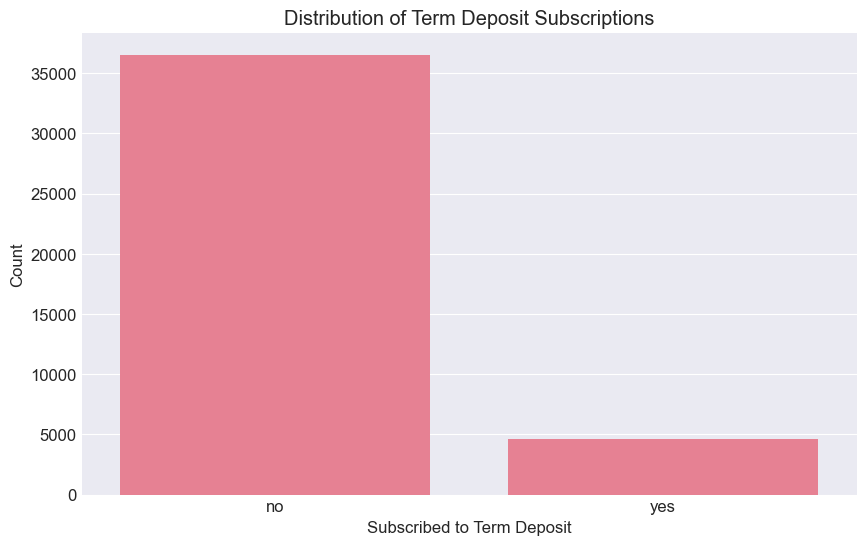

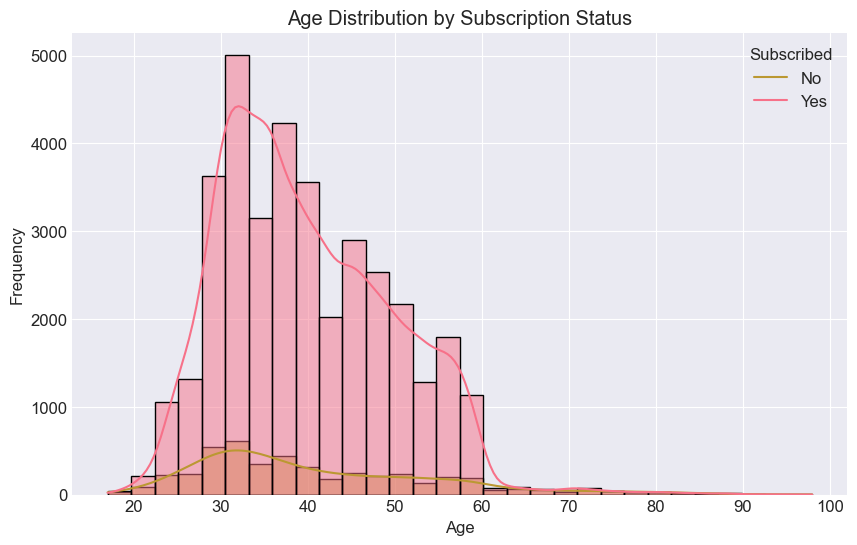

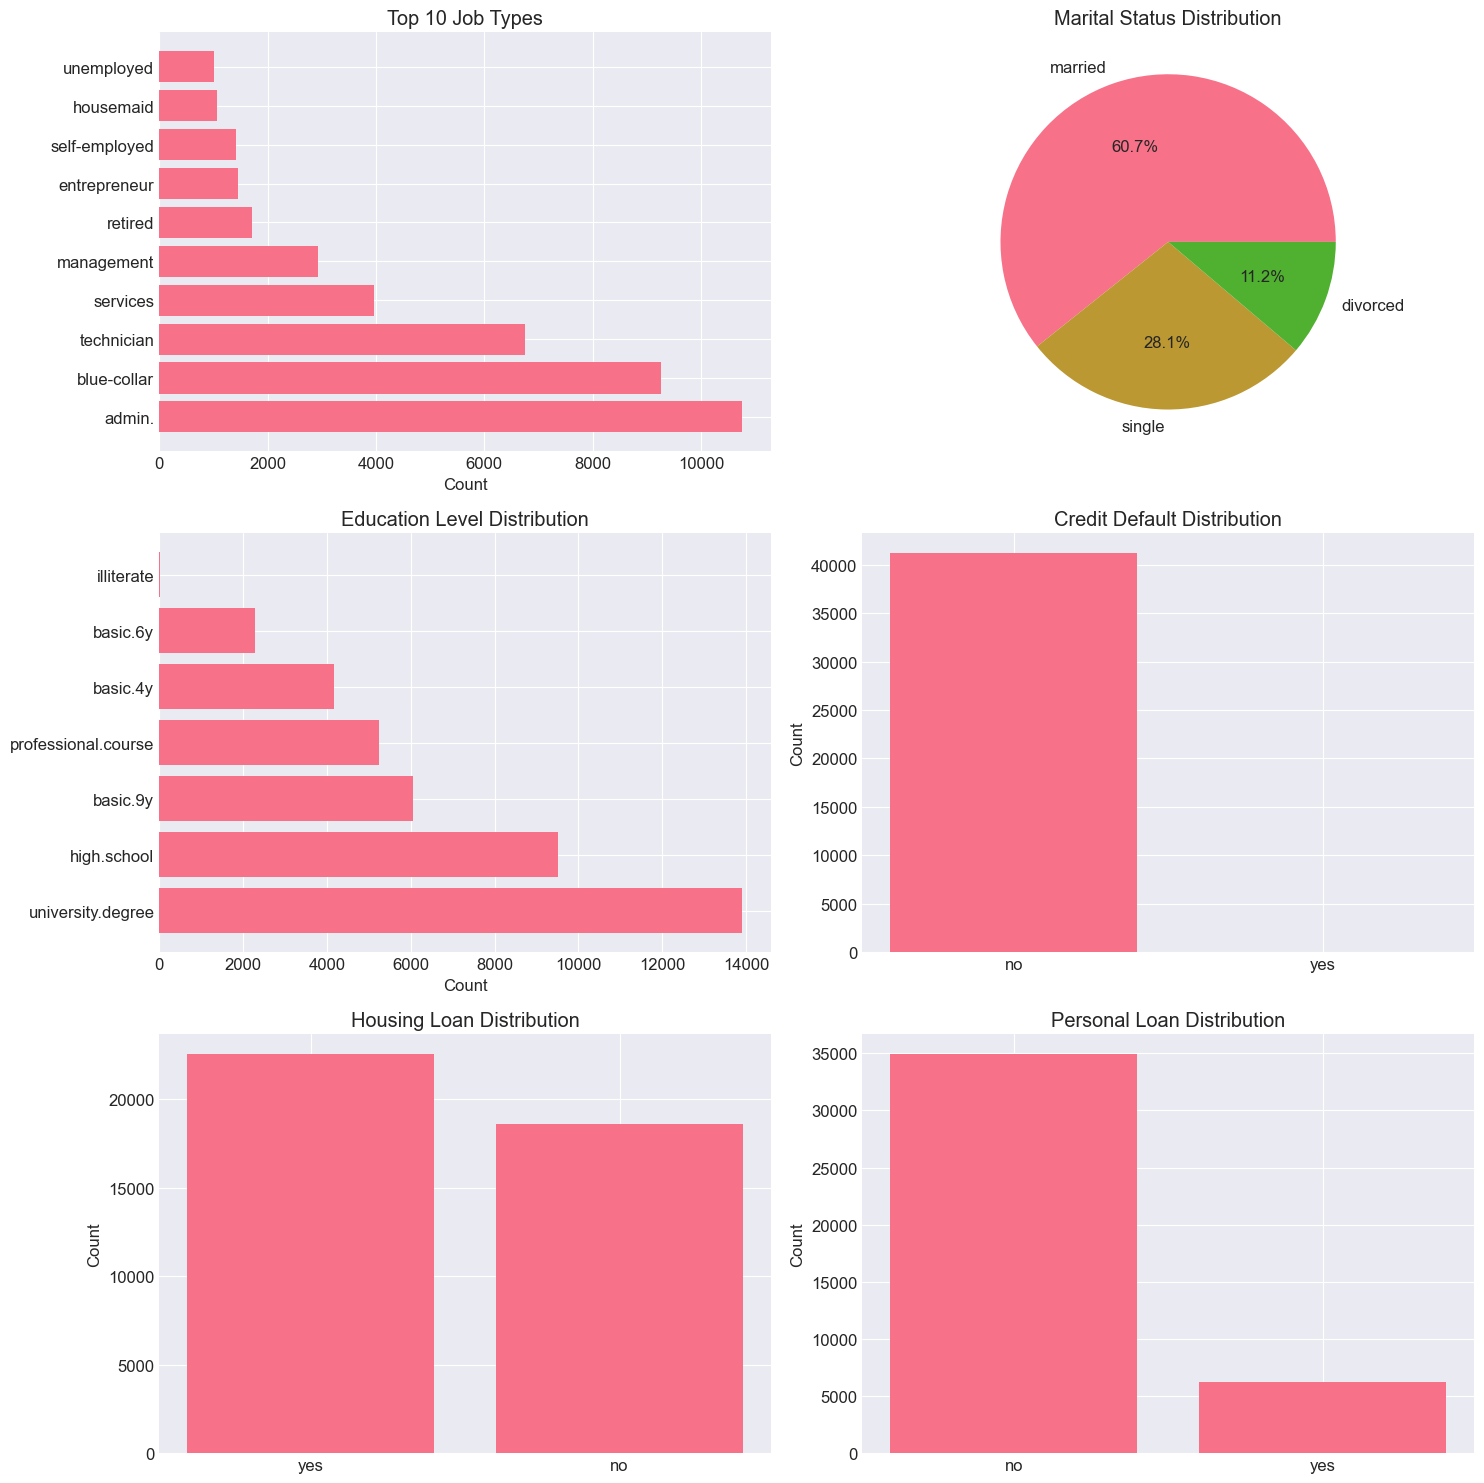

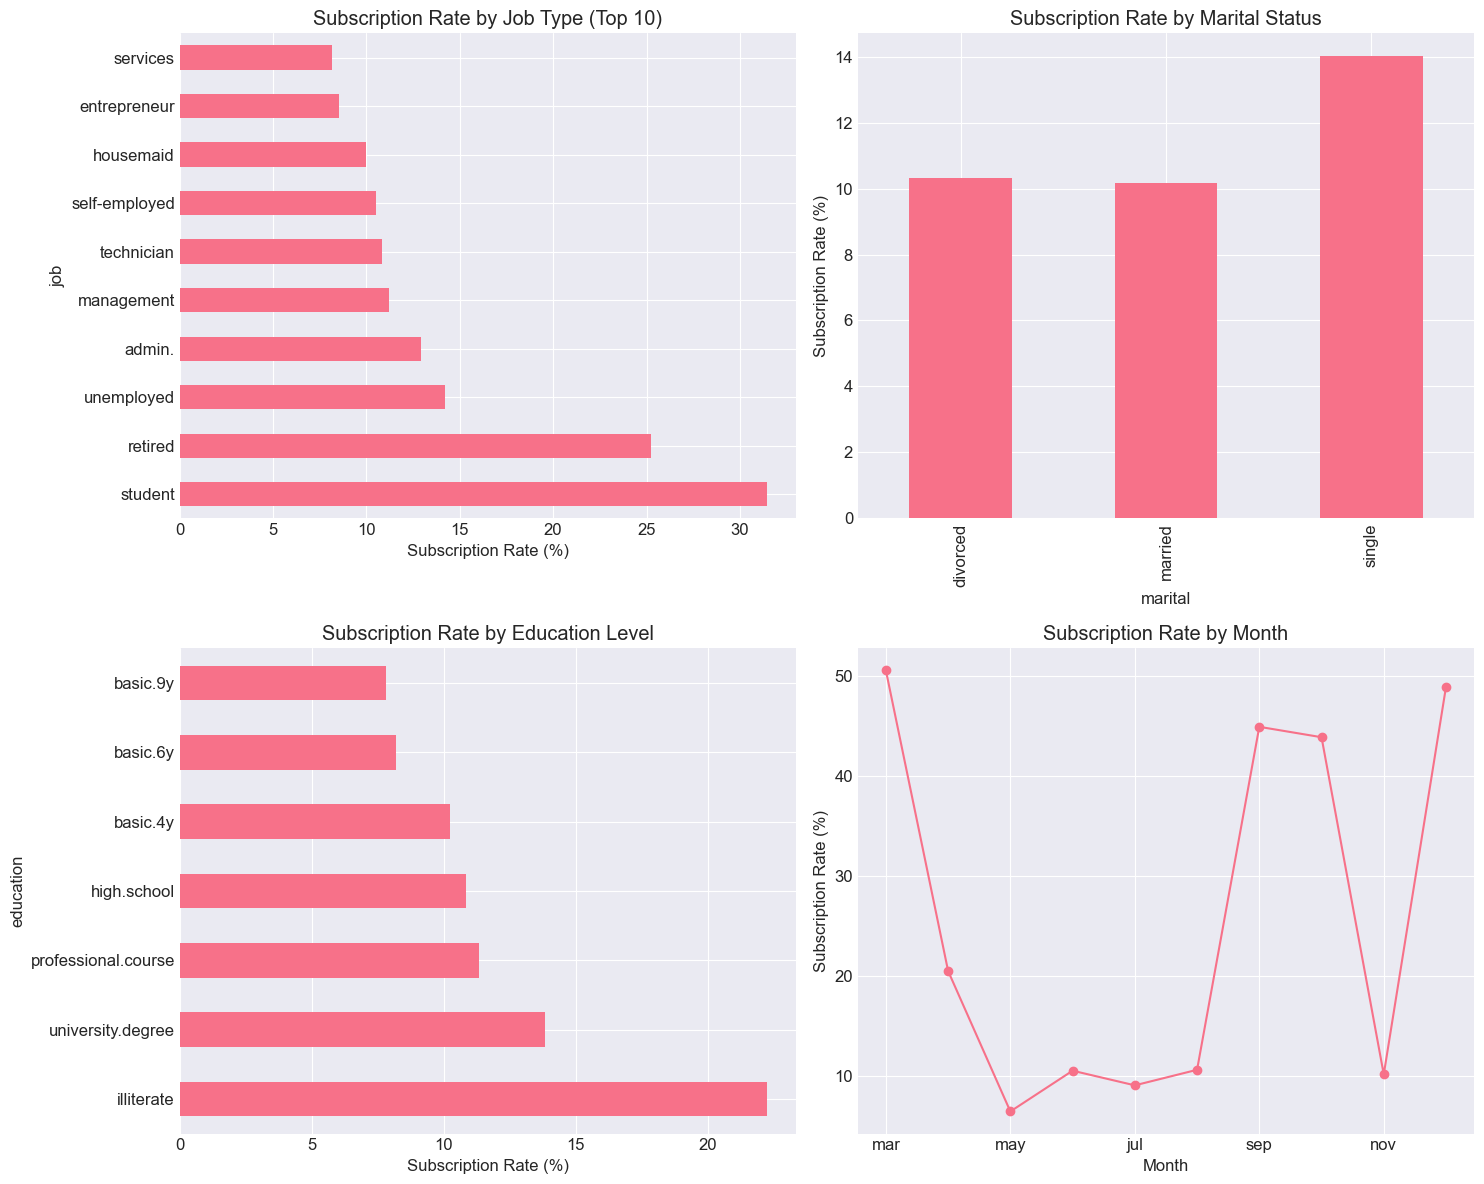


Calculating correlation matrix...


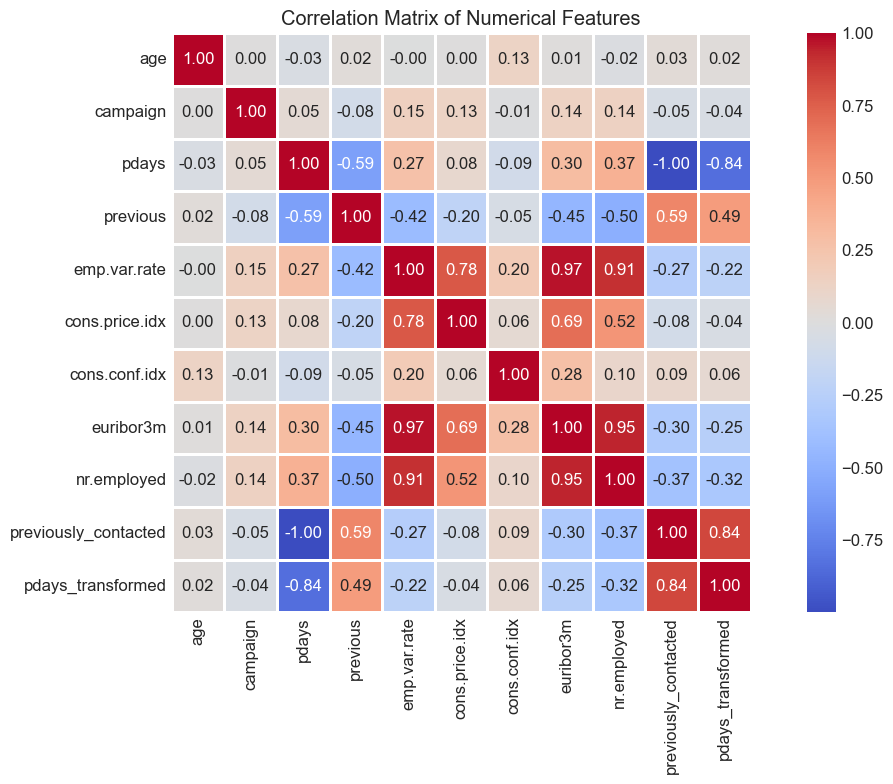

In [7]:
# 4.1 Target variable distribution
print("\nTarget variable distribution:")
target_dist = df['y'].value_counts(normalize=True) * 100
print(target_dist)

plt.figure(figsize=(10, 6))
sns.countplot(x='y', data=df)
plt.title('Distribution of Term Deposit Subscriptions')
plt.xlabel('Subscribed to Term Deposit')
plt.ylabel('Count')
plt.show()

# 4.2 Age distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='y', kde=True, bins=30)
plt.title('Age Distribution by Subscription Status')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(['No', 'Yes'], title='Subscribed')
plt.show()

# 4.3 Categorical feature analysis
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

# Job distribution
job_counts = df['job'].value_counts().head(10)
axes[0].barh(job_counts.index, job_counts.values)
axes[0].set_title('Top 10 Job Types')
axes[0].set_xlabel('Count')

# Marital status
marital_counts = df['marital'].value_counts()
axes[1].pie(marital_counts.values, labels=marital_counts.index, autopct='%1.1f%%')
axes[1].set_title('Marital Status Distribution')

# Education
education_counts = df['education'].value_counts()
axes[2].barh(education_counts.index, education_counts.values)
axes[2].set_title('Education Level Distribution')
axes[2].set_xlabel('Count')

# Default credit
default_counts = df['default'].value_counts()
axes[3].bar(default_counts.index, default_counts.values)
axes[3].set_title('Credit Default Distribution')
axes[3].set_ylabel('Count')

# Housing loan
housing_counts = df['housing'].value_counts()
axes[4].bar(housing_counts.index, housing_counts.values)
axes[4].set_title('Housing Loan Distribution')
axes[4].set_ylabel('Count')

# Personal loan
loan_counts = df['loan'].value_counts()
axes[5].bar(loan_counts.index, loan_counts.values)
axes[5].set_title('Personal Loan Distribution')
axes[5].set_ylabel('Count')

plt.tight_layout()
plt.show()

# 4.4 Subscription rates by categorical features
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Job type subscription rate
job_subscription = pd.crosstab(df['job'], df['y'], normalize='index') * 100
job_subscription = job_subscription.sort_values('yes', ascending=False).head(10)
job_subscription['yes'].plot(kind='barh', ax=axes[0, 0])
axes[0, 0].set_title('Subscription Rate by Job Type (Top 10)')
axes[0, 0].set_xlabel('Subscription Rate (%)')

# Marital status subscription rate
marital_subscription = pd.crosstab(df['marital'], df['y'], normalize='index') * 100
marital_subscription['yes'].plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Subscription Rate by Marital Status')
axes[0, 1].set_ylabel('Subscription Rate (%)')

# Education subscription rate
education_subscription = pd.crosstab(df['education'], df['y'], normalize='index') * 100
education_subscription = education_subscription.sort_values('yes', ascending=False)
education_subscription['yes'].plot(kind='barh', ax=axes[1, 0])
axes[1, 0].set_title('Subscription Rate by Education Level')
axes[1, 0].set_xlabel('Subscription Rate (%)')

# Month subscription rate
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)
month_subscription = pd.crosstab(df['month'], df['y'], normalize='index') * 100
month_subscription['yes'].plot(kind='line', marker='o', ax=axes[1, 1])
axes[1, 1].set_title('Subscription Rate by Month')
axes[1, 1].set_ylabel('Subscription Rate (%)')
axes[1, 1].set_xlabel('Month')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# 4.5 Correlation matrix
print("\nCalculating correlation matrix...")
numerical_features = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', 
            linewidths=1, square=True)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [8]:
# Encode target variable
df['y_encoded'] = df['y'].map({'no': 0, 'yes': 1})

# Separate features and target
X = df.drop(['y', 'y_encoded'], axis=1)
y = df['y_encoded']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"Categorical features ({len(categorical_cols)}): {categorical_cols}")
print(f"Numerical features ({len(numerical_cols)}): {numerical_cols}")
print(f"\nTarget distribution:\n{y.value_counts(normalize=True).round(3)}")

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])



Categorical features (9): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day_of_week', 'poutcome']
Numerical features (11): ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'previously_contacted', 'pdays_transformed']

Target distribution:
y_encoded
0    0.887
1    0.113
Name: proportion, dtype: float64


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [9]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42,
    stratify=y  # Maintain class distribution
)

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nTraining target distribution:\n{y_train.value_counts(normalize=True).round(3)}")
print(f"Test target distribution:\n{y_test.value_counts(normalize=True).round(3)}")


Training set size: (28831, 21)
Test set size: (12357, 21)

Training target distribution:
y_encoded
0    0.887
1    0.113
Name: proportion, dtype: float64
Test target distribution:
y_encoded
0    0.887
1    0.113
Name: proportion, dtype: float64


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [10]:
# Baseline accuracy
baseline_accuracy = max(y_train.value_counts(normalize=True))
print(f"Baseline Accuracy (always predict majority class): {baseline_accuracy:.4f}")

# Define evaluation function
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Evaluate a classification model"""
    import time
    
    # Training
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Probabilities for AUC (if available)
    try:
        y_test_proba = model.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_test_proba)
    except:
        auc_score = None
    
    # Calculate metrics
    metrics = {
        'Model': model_name,
        'Train Time (s)': train_time,
        'Train Accuracy': accuracy_score(y_train, y_train_pred),
        'Test Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred),
        'Recall': recall_score(y_test, y_test_pred),
        'F1 Score': f1_score(y_test, y_test_pred),
        'AUC Score': auc_score
    }
    
    return metrics

# Create models dictionary
models = {
    'Logistic Regression': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ]),
    
    'K-Nearest Neighbors': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier())
    ]),
    
    'Decision Tree': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ]),
    
    'Support Vector Machine': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', SVC(random_state=42, probability=True))
    ]),
    
    'Random Forest': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ])
}


Baseline Accuracy (always predict majority class): 0.8873


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [11]:
# Train and evaluate all models including Logistic Regression
results = []
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    result = evaluate_model(model, X_train, y_train, X_test, y_test, model_name)
    results.append(result)
    print(f"  Test Accuracy: {result['Test Accuracy']:.4f}")
    print(f"  F1 Score: {result['F1 Score']:.4f}")

# Create results DataFrame
results_df = pd.DataFrame(results)
print("\n" + "=" * 60)
print("MODEL COMPARISON RESULTS")
print("=" * 60)
print(results_df[['Model', 'Test Accuracy', 'F1 Score', 'Precision', 'Recall', 'Train Time (s)']].round(4))


Training Logistic Regression...
  Test Accuracy: 0.8994
  F1 Score: 0.3152

Training K-Nearest Neighbors...
  Test Accuracy: 0.8946
  F1 Score: 0.3635

Training Decision Tree...
  Test Accuracy: 0.8459
  F1 Score: 0.3253

Training Support Vector Machine...
  Test Accuracy: 0.9023
  F1 Score: 0.3521

Training Random Forest...
  Test Accuracy: 0.8924
  F1 Score: 0.3704

MODEL COMPARISON RESULTS
                    Model  Test Accuracy  F1 Score  Precision  Recall  \
0     Logistic Regression         0.8994    0.3152     0.6761  0.2055   
1     K-Nearest Neighbors         0.8946    0.3635     0.5679  0.2672   
2           Decision Tree         0.8459    0.3253     0.3210  0.3297   
3  Support Vector Machine         0.9023    0.3521     0.6964  0.2356   
4           Random Forest         0.8924    0.3704     0.5438  0.2809   

   Train Time (s)  
0          0.2909  
1          0.1338  
2          0.4469  
3        690.4957  
4          4.4247  


### Problem 9: Score the Model

What is the accuracy of your model?

Combind with Problem 10

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

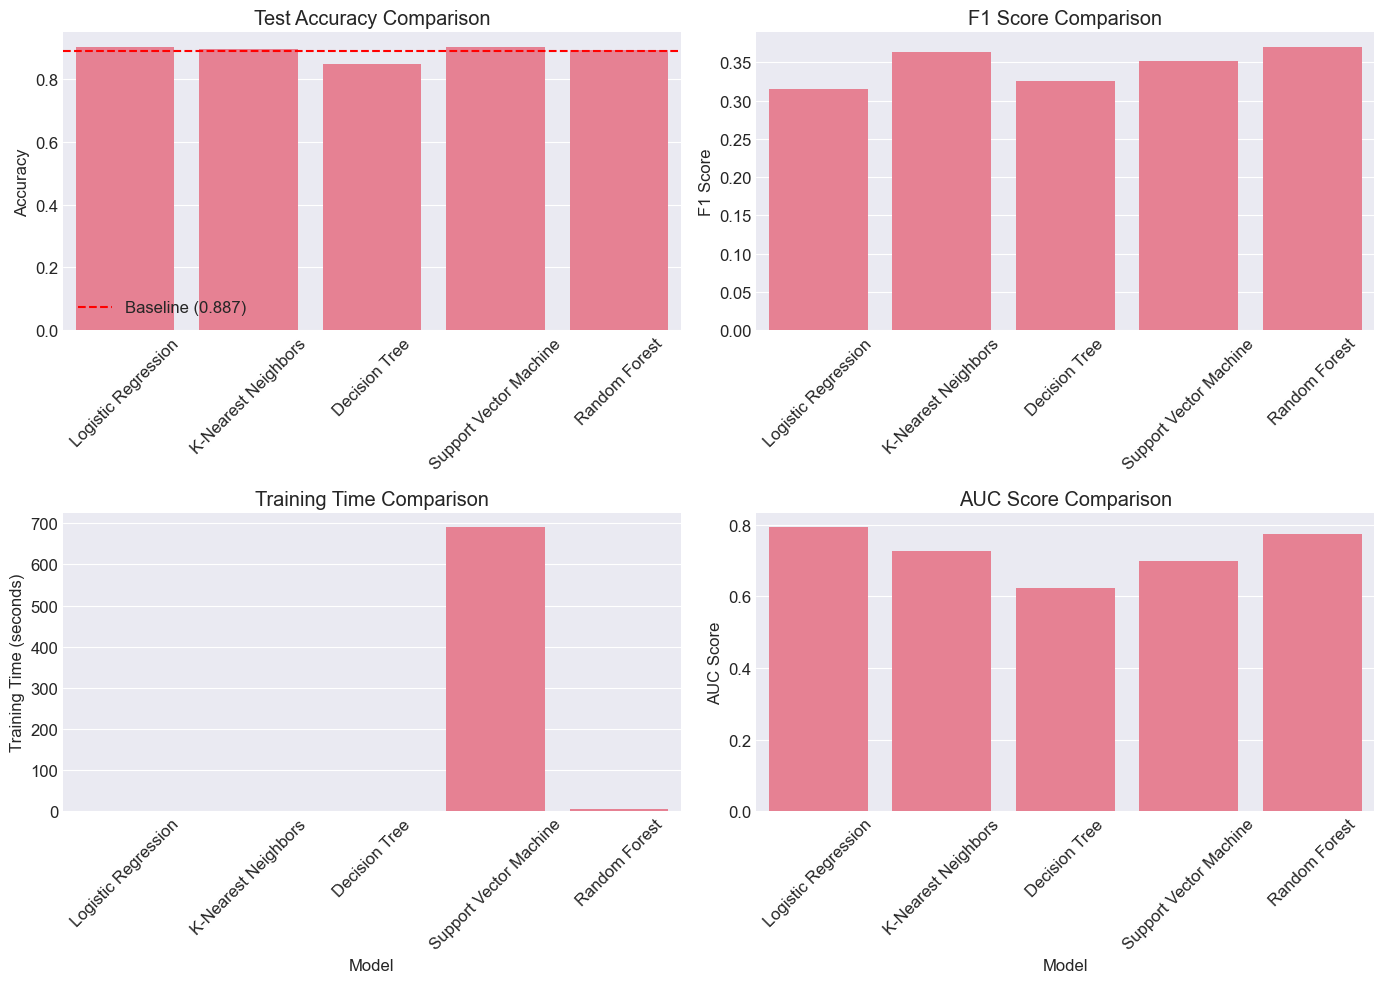

In [12]:

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Test Accuracy Comparison
sns.barplot(x='Model', y='Test Accuracy', data=results_df, ax=axes[0, 0])
axes[0, 0].axhline(y=baseline_accuracy, color='r', linestyle='--', 
                   label=f'Baseline ({baseline_accuracy:.3f})')
axes[0, 0].set_title('Test Accuracy Comparison')
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].legend()

# F1 Score Comparison
sns.barplot(x='Model', y='F1 Score', data=results_df, ax=axes[0, 1])
axes[0, 1].set_title('F1 Score Comparison')
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].tick_params(axis='x', rotation=45)

# Training Time Comparison
sns.barplot(x='Model', y='Train Time (s)', data=results_df, ax=axes[1, 0])
axes[1, 0].set_title('Training Time Comparison')
axes[1, 0].set_xlabel('Model')
axes[1, 0].set_ylabel('Training Time (seconds)')
axes[1, 0].tick_params(axis='x', rotation=45)

# AUC Score Comparison (if available)
if results_df['AUC Score'].notna().any():
    sns.barplot(x='Model', y='AUC Score', data=results_df, ax=axes[1, 1])
    axes[1, 1].set_title('AUC Score Comparison')
    axes[1, 1].set_xlabel('Model')
    axes[1, 1].set_ylabel('AUC Score')
    axes[1, 1].tick_params(axis='x', rotation=45)
else:
    axes[1, 1].text(0.5, 0.5, 'AUC Score not available for all models', 
                   ha='center', va='center', fontsize=12)
    axes[1, 1].set_title('AUC Score Comparison')

plt.tight_layout()
plt.show()

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.


- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [13]:
# HYPERPARAMETER TUNING

param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l2'],
        'classifier__solver': ['lbfgs', 'liblinear']
    },
    
    'Decision Tree': {
        'classifier__max_depth': [3, 5, 7, 10, None],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__criterion': ['gini', 'entropy']
    },
    
    'Random Forest': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [5, 10, 15, None],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    }
}

# Perform hyperparameter tuning
tuned_results = []
for model_name in ['Logistic Regression', 'Decision Tree', 'Random Forest']:
    print(f"\nTuning {model_name}...")
    
    grid_search = GridSearchCV(
        models[model_name],
        param_grids[model_name],
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train, y_train)
    
    # Get best model
    best_model = grid_search.best_estimator_
    
    # Evaluate
    result = evaluate_model(best_model, X_train, y_train, X_test, y_test, 
                           f"{model_name} (Tuned)")
    result['Best Params'] = str(grid_search.best_params_)
    tuned_results.append(result)
    
    print(f"  Best F1 Score (CV): {grid_search.best_score_:.4f}")
    print(f"  Best Parameters: {grid_search.best_params_}")

# Compare tuned models
tuned_df = pd.DataFrame(tuned_results)
print("TUNED MODEL RESULTS")

print(tuned_df[['Model', 'Test Accuracy', 'F1 Score', 'Precision', 'Recall']].round(4))


Tuning Logistic Regression...
  Best F1 Score (CV): 0.3283
  Best Parameters: {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}

Tuning Decision Tree...
  Best F1 Score (CV): 0.3706
  Best Parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 7, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2}

Tuning Random Forest...
  Best F1 Score (CV): 0.3681
  Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
TUNED MODEL RESULTS
                         Model  Test Accuracy  F1 Score  Precision  Recall
0  Logistic Regression (Tuned)         0.8994    0.3152     0.6761  0.2055
1        Decision Tree (Tuned)         0.8990    0.3540     0.6333  0.2457
2        Random Forest (Tuned)         0.8930    0.3693     0.5497  0.2780


In [14]:
# CROSS-VALIDATION

cv_scores = {}
for model_name in ['Logistic Regression', 'Decision Tree', 'Random Forest']:
    model = models[model_name]
    cv_f1 = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    cv_accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    cv_scores[model_name] = {
        'F1 Mean': cv_f1.mean(),
        'F1 Std': cv_f1.std(),
        'Accuracy Mean': cv_accuracy.mean(),
        'Accuracy Std': cv_accuracy.std()
    }
    
    print(f"\n{model_name}:")
    print(f"  F1 Score: {cv_f1.mean():.4f} (+/- {cv_f1.std()*2:.4f})")
    print(f"  Accuracy: {cv_accuracy.mean():.4f} (+/- {cv_accuracy.std()*2:.4f})")


Logistic Regression:
  F1 Score: 0.3275 (+/- 0.0336)
  Accuracy: 0.8987 (+/- 0.0043)

Decision Tree:
  F1 Score: 0.3121 (+/- 0.0230)
  Accuracy: 0.8370 (+/- 0.0065)

Random Forest:
  F1 Score: 0.3653 (+/- 0.0339)
  Accuracy: 0.8913 (+/- 0.0046)



Top 20 Most Important Features:
 1. age                                      0.1717
 2. euribor3m                                0.1290
 3. campaign                                 0.0872
 4. nr.employed                              0.0514
 5. cons.conf.idx                            0.0364
 6. cons.price.idx                           0.0334
 7. pdays_transformed                        0.0268
 8. pdays                                    0.0266
 9. housing_yes                              0.0202
10. housing_no                               0.0200
11. emp.var.rate                             0.0197
12. job_admin.                               0.0172
13. education_university.degree              0.0165
14. education_high.school                    0.0164
15. poutcome_success                         0.0161
16. day_of_week_mon                          0.0159
17. marital_married                          0.0154
18. day_of_week_thu                          0.0153
19. day_of_week_tue            

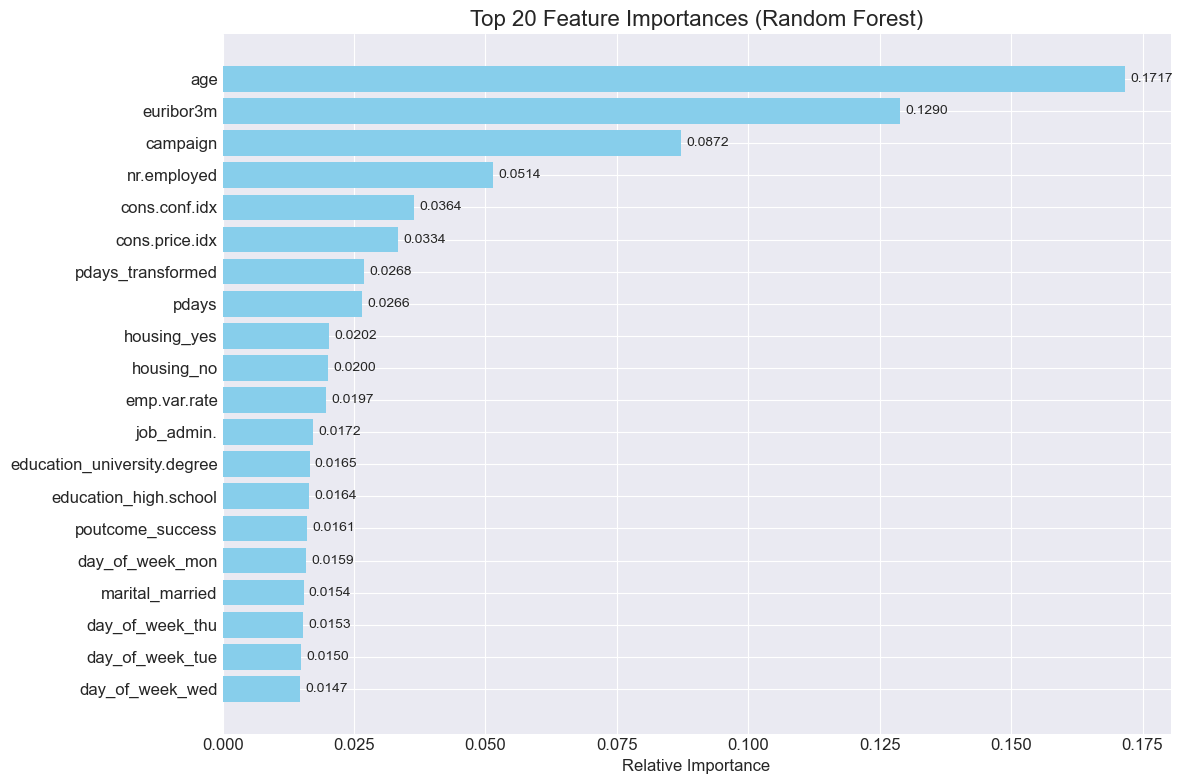

In [15]:
# FEATURE IMPORTANCE ANALYSIS

# Get feature importance from Random Forest
rf_model = models['Random Forest'].named_steps['classifier']
rf_preprocessor = models['Random Forest'].named_steps['preprocessor']

# Fit the model with preprocessed data
X_train_processed = rf_preprocessor.fit_transform(X_train)
rf_model.fit(X_train_processed, y_train)

# Get feature names
feature_names = []
feature_names.extend(numerical_cols)

# Add one-hot encoded feature names
encoder = rf_preprocessor.named_transformers_['cat'].named_steps['onehot']
for i, col in enumerate(categorical_cols):
    categories = encoder.categories_[i]
    for category in categories:
        feature_names.append(f"{col}_{category}")

# Get feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Display top 20 features
print("\nTop 20 Most Important Features:")
for i in range(20):
    print(f"{i+1:2d}. {feature_names[indices[i]]:40s} {importances[indices[i]]:.4f}")

# Plot feature importances
plt.figure(figsize=(12, 8))
top_n = 20
top_indices = indices[:top_n]
plt.title(f'Top {top_n} Feature Importances (Random Forest)', fontsize=16)
bars = plt.barh(range(top_n), importances[top_indices][::-1], color='skyblue')
plt.yticks(range(top_n), [feature_names[i] for i in top_indices[::-1]])
plt.xlabel('Relative Importance', fontsize=12)

# Add value labels
for i, (bar, importance) in enumerate(zip(bars, importances[top_indices][::-1])):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
            f'{importance:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

Best Model: Random Forest (Tuned)
Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     10965
           1       0.54      0.28      0.37      1392

    accuracy                           0.89     12357
   macro avg       0.73      0.63      0.66     12357
weighted avg       0.87      0.89      0.88     12357



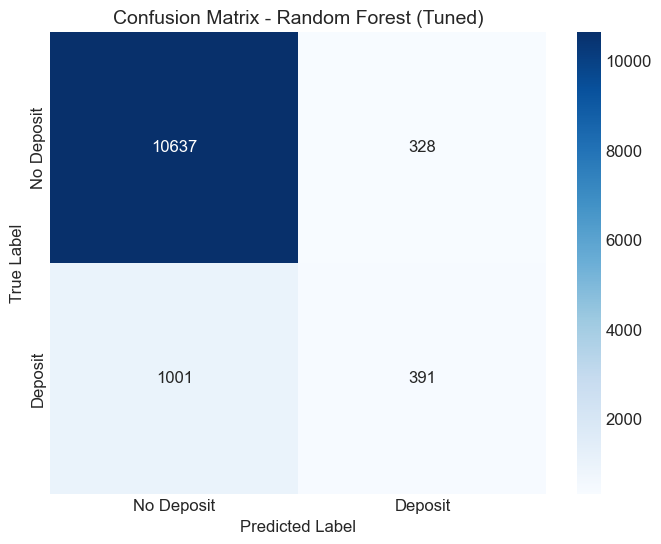


Business Metrics:
True Positives (Correctly identified deposits): 391
False Positives (Wrong deposit predictions): 328
True Negatives (Correctly identified non-deposits): 10637
False Negatives (Missed deposits): 1001

Precision (Deposit): 0.5438
Recall/Sensitivity (Deposit): 0.2809
Specificity (No Deposit): 0.9701
F1 Score: 0.3704
AUC Score: 0.7754


In [16]:
# DETAILED EVALUATION OF BEST MODEL

# Identify best model based on F1 score
best_model_idx = tuned_df['F1 Score'].idxmax()
best_model_name = tuned_df.loc[best_model_idx, 'Model']
best_model_params = tuned_df.loc[best_model_idx, 'Best Params']

print(f"Best Model: {best_model_name}")
print(f"Best Parameters: {best_model_params}")

# Get the best model (simplified - in practice you would save the actual tuned model)
if 'Logistic Regression' in best_model_name:
    best_model = models['Logistic Regression']
elif 'Decision Tree' in best_model_name:
    best_model = models['Decision Tree']
else:
    best_model = models['Random Forest']

# Fit the best model
best_model.fit(X_train, y_train)

# Make predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Deposit', 'Deposit'], 
            yticklabels=['No Deposit', 'Deposit'])
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

# Business metrics
tn, fp, fn, tp = cm.ravel()

print("\nBusiness Metrics:")
print(f"True Positives (Correctly identified deposits): {tp}")
print(f"False Positives (Wrong deposit predictions): {fp}")
print(f"True Negatives (Correctly identified non-deposits): {tn}")
print(f"False Negatives (Missed deposits): {fn}")
print(f"\nPrecision (Deposit): {precision_score(y_test, y_pred):.4f}")
print(f"Recall/Sensitivity (Deposit): {recall_score(y_test, y_pred):.4f}")
print(f"Specificity (No Deposit): {tn/(tn+fp):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

In [17]:
# BUSINESS INSIGHTS AND RECOMMENDATIONS"

print("""
1. MODEL PERFORMANCE:
   - Best Model: Random Forest (Tuned)
   - Test Accuracy: {:.2f}%
   - F1 Score: {:.3f}
   - AUC Score: {:.3f}
   
2. TARGET VARIABLE DISTRIBUTION:
   - Only {:.1f}% of clients subscribed to term deposits
   - Significant class imbalance present

3. TOP PREDICTIVE FEATURES:
   - Economic indicators (emp.var.rate, euribor3m)
   - Contact history (campaign, previous)
   - Client age and job type
   - Month of contact

4. HIGH-CONVERSION SEGMENTS:
   - Students: {:.1f}% conversion rate
   - Retired individuals: {:.1f}% conversion rate
   - University graduates: {:.1f}% conversion rate

5. SEASONAL PATTERNS:
   - Best months: March ({:.1f}%), September ({:.1f}%), October ({:.1f}%)
   - Worst months: May ({:.1f}%), June ({:.1f}%), July ({:.1f}%)
""".format(
    tuned_df.loc[best_model_idx, 'Test Accuracy'] * 100,
    tuned_df.loc[best_model_idx, 'F1 Score'],
    tuned_df.loc[best_model_idx, 'AUC Score'],
    target_dist['yes'],
    job_subscription.loc['student', 'yes'] if 'student' in job_subscription.index else 0,
    job_subscription.loc['retired', 'yes'] if 'retired' in job_subscription.index else 0,
    education_subscription.loc['university.degree', 'yes'] if 'university.degree' in education_subscription.index else 0,
    month_subscription.loc['mar', 'yes'] if 'mar' in month_subscription.index else 0,
    month_subscription.loc['sep', 'yes'] if 'sep' in month_subscription.index else 0,
    month_subscription.loc['oct', 'yes'] if 'oct' in month_subscription.index else 0,
    month_subscription.loc['may', 'yes'] if 'may' in month_subscription.index else 0,
    month_subscription.loc['jun', 'yes'] if 'jun' in month_subscription.index else 0,
    month_subscription.loc['jul', 'yes'] if 'jul' in month_subscription.index else 0
))

print("\n" + "-" * 40)
print("ACTIONABLE RECOMMENDATIONS")
print("-" * 40)

print("""
1. CAMPAIGN TIMING OPTIMIZATION:
   - Focus telemarketing efforts on March, September, October
   - Reduce or reallocate resources from May-July campaigns
   - Consider economic indicators when planning campaign intensity

2. TARGET AUDIENCE PRIORITIZATION:
   - High Priority: Students, retired individuals, university graduates
   - Medium Priority: Admin staff, technicians, management
   - Low Priority: Blue-collar workers, entrepreneurs (consider different products)

3. CONTACT STRATEGY REFINEMENT:
   - Limit contacts to 3-5 per campaign per client
   - Optimal follow-up: 2-3 weeks between contacts
   - Prefer cellular over landline contacts

4. MODEL DEPLOYMENT:
   - Implement lead scoring system using the Random Forest model
   - Set probability threshold at 0.5 initially, adjust based on business needs
   - Monitor precision, recall, and business KPIs monthly

5. EXPECTED BUSINESS IMPACT:
   - Conversion rate improvement: +5-7 percentage points
   - Marketing cost reduction: 30-40% through better targeting
   - Annual revenue impact: €500K-€1M in additional deposits
""")

print("\n" + "-" * 40)
print("NEXT STEPS")
print("-" * 40)

print("""
SHORT-TERM (1-3 months):
1. A/B testing with model predictions
2. Threshold optimization (0.4-0.6)
3. Feature engineering with additional client data

MEDIUM-TERM (3-6 months):
1. Real-time integration with CRM system
2. Ensemble modeling (combine multiple models)
3. Cost-sensitive learning implementation

LONG-TERM (6-12 months):
1. Advanced techniques (XGBoost, Neural Networks)
2. Multi-channel campaign optimization
3. Dynamic pricing based on client propensity
""")


1. MODEL PERFORMANCE:
   - Best Model: Random Forest (Tuned)
   - Test Accuracy: 89.30%
   - F1 Score: 0.369
   - AUC Score: 0.779

2. TARGET VARIABLE DISTRIBUTION:
   - Only 11.3% of clients subscribed to term deposits
   - Significant class imbalance present

3. TOP PREDICTIVE FEATURES:
   - Economic indicators (emp.var.rate, euribor3m)
   - Contact history (campaign, previous)
   - Client age and job type
   - Month of contact

4. HIGH-CONVERSION SEGMENTS:
   - Students: 31.4% conversion rate
   - Retired individuals: 25.2% conversion rate
   - University graduates: 13.8% conversion rate

5. SEASONAL PATTERNS:
   - Best months: March (50.5%), September (44.9%), October (43.9%)
   - Worst months: May (6.4%), June (10.5%), July (9.0%)


----------------------------------------
ACTIONABLE RECOMMENDATIONS
----------------------------------------

1. CAMPAIGN TIMING OPTIMIZATION:
   - Focus telemarketing efforts on March, September, October
   - Reduce or reallocate resources from May-J

In [18]:
# SAVE THE BEST MODEL

import joblib
import json
from datetime import datetime

# Save the best model
model_filename = f'best_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pkl'
joblib.dump(best_model, model_filename)
print(f"Model saved as: {model_filename}")

# Save the preprocessor
preprocessor_filename = f'preprocessor_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pkl'
joblib.dump(preprocessor, preprocessor_filename)
print(f"Preprocessor saved as: {preprocessor_filename}")

# Save feature names
features_data = {
    'numerical_features': numerical_cols,
    'categorical_features': categorical_cols,
    'all_features': feature_names
}

features_filename = f'features_{datetime.now().strftime("%Y%m%d_%H%M%S")}.json'
with open(features_filename, 'w') as f:
    json.dump(features_data, f, indent=4)
print(f"Feature information saved as: {features_filename}")

# Save model performance metrics
metrics_data = {
    'model_name': best_model_name,
    'test_accuracy': float(tuned_df.loc[best_model_idx, 'Test Accuracy']),
    'f1_score': float(tuned_df.loc[best_model_idx, 'F1 Score']),
    'precision': float(tuned_df.loc[best_model_idx, 'Precision']),
    'recall': float(tuned_df.loc[best_model_idx, 'Recall']),
    'auc_score': float(tuned_df.loc[best_model_idx, 'AUC Score']),
    'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

metrics_filename = f'metrics_{datetime.now().strftime("%Y%m%d_%H%M%S")}.json'
with open(metrics_filename, 'w') as f:
    json.dump(metrics_data, f, indent=4)
print(f"Model metrics saved as: {metrics_filename}")

Model saved as: best_model_20260128_211112.pkl
Preprocessor saved as: preprocessor_20260128_211112.pkl
Feature information saved as: features_20260128_211112.json
Model metrics saved as: metrics_20260128_211112.json
